# Homework 6

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn
import time
import scipy.optimize as opt

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with standard deviation `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [2]:
def gen_lstsq(n, p, sig=0.1):
    """
    Generates a linear least squares problem y = X @ b
    where b is the ground truth solution
    """
    
    # Initialize arrays
    X = np.random.randn(n,p)
    b = np.random.randn(p)
    y = np.zeros(n)
    
    # Calculate y
    for i in range(n):
        y[i] = np.dot(X[i], b) + sig * np.random.randn()
    
    return X, y, b

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [3]:
def solve_lstsq_qr(X, y):
    """
    Solves the least squares problem using QR factorization (X = QR)
    and returns bhat = R^-1 @ Q.T @ y
    """
    
    # Find QR factorization of X
    Q, R = la.qr(X, mode='economic')

    # Solve for bhat_qr
    bhat_qr = la.solve_triangular(R, Q.T @ y, lower=False)
    
    return bhat_qr

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [4]:
def solve_lstsq_normal(X, y):
    """
    Solves the least squares problem using the normal equation X.T @ X @ bhat = X.T @ b
    and returns bhat = (X.T @ X)^-1 X.T @ y using cholesky decomposition 
    """
    
    # Get cholesky decomposition of X
    U = la.cholesky(X.T @ X)
    
    # Solve for bhat_n (normal)
    bhat_n = la.solve_triangular(
            U,
            la.solve_triangular(
                U.T, 
                X.T @ y, 
                lower=True
            ),
            lower=False
        )    
        
    return bhat_n

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [5]:
# Initialize error lists for each method
err1 = []
err2 = []
err3 = []

# Loops over the functions 3 times
for i in range(3):

    # Find random integer for n and p where p < n
    n = np.random.randint(5, 50)
    p = np.random.randint(1, n-1)

    # Generate the least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Solve the problem using QR factorization and the normal equation
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_n = solve_lstsq_normal(X, y)
    
    # Solve the problem using scipy lstsq module
    bhat = la.lstsq(X, y)[0]

    # Calculate the norm of (bhat_1 - bhat_2) for two functions at a time and store it in the respective err list
    # Then perform a check to make sure each error being added is less than the tolerance
    
    err1.append(la.norm(bhat_qr - bhat_n, ord=2))
    assert err1[i] < 1e-4, "Error larger than 1e-4"

    err2.append(la.norm(bhat_qr - bhat, ord=2))
    assert err2[i] < 1e-4, "Error larger than 1e-4"
    
    err3.append(la.norm(bhat_n - bhat, ord=2))
    assert err3[i] < 1e-4, "Error larger than 1e-4"


### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

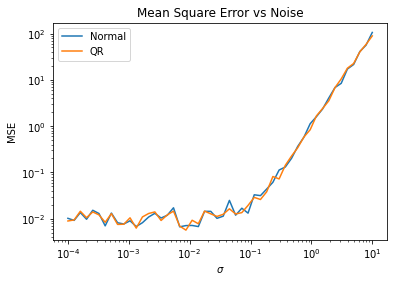

In [6]:
def mse(b, bhat, N=100, sig=0.1):
    """
    Estimates the mean squared error (MSE) given a ground truth solution b and an estimated solution bhat
    """
    
    # Generate a matrix X
    p = len(b)
    X = np.random.randn(N, p)

    # Calculate the solution y from X and ground truth solution b
    y = X @ b + sig * np.random.randn(N)
    
    # Calculate the MSE
    MSE = 1/N * np.dot(X @ bhat - y, X @ bhat - y)
    
    return MSE

# Initialize parameters and lists
sig = np.logspace(-4, 1)
MSE_n = []
MSE_qr = []
n = 100
p = 50
N = 100

# Loop over all values in list of sig
for s in sig:
    # Generate the least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Solve for bhat using each method
    bhat_n = solve_lstsq_normal(X, y)
    bhat_qr = solve_lstsq_qr(X, y)
    
    # Append the MSE of each method to the respective list
    MSE_n.append(mse(b, bhat_n, N, s))
    MSE_qr.append(mse(b, bhat_qr, N, s))


# Plot the MSE against the values of sig
plt.plot(sig, MSE_n, label='Normal')
plt.plot(sig, MSE_qr, label='QR')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\sigma$')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [7]:
# Generate least squares problems
n = 100
p = 50
X, y, b = gen_lstsq(n, p)

# Calculate time for QR factorization method
t0 = time.time()
bhat_qr = solve_lstsq_qr(X, y)
t1 = time.time()
print("Time for lstsq_qr {} sec.".format(t1 - t0))

# Calculate time for normal equation method
t2 = time.time()
bhat_n = solve_lstsq_normal(X, y)
t3 = time.time()
print("Time for lstsq_normal {} sec.".format(t3 - t2))

Time for lstsq_qr 0.0004546642303466797 sec.
Time for lstsq_normal 0.0006711483001708984 sec.


---
I think they're very similar in run times. Occasionally the run times of one is faster than the other but it keeps changing which one is faster so I'm not really sure if one is ultimately always faster.

### Optimization

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [8]:
def solve_lstsq_opt(X, y):
    """
    Solves the least squares problem using the minimization method
    minimize_b (1/n * la.norm(X * b - y)**2)
    """
    
    p = np.shape(X)[1]
    
    # I'm using g instead of b, cause I already have a 'b' defined in previous cells 
    # and I think the notebook was getting confused
    
    # Define the function to be minimized
    f = lambda g : (1/n) * np.dot(X @ g - y, X @ g - y)
    
    # Define its jacobian
    j = lambda g : (2/n) * np.dot(g, X.T @ X) - (2/n) * np.dot(y, X)
    
    # Solve the minimization problem using the function and the jacobian
    sol = opt.minimize(f, np.zeros(p), jac=j)
    
    return sol.x

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [9]:
# Initialize error lists for each method
err1 = []
err2 = []

# Loops over the functions 3 times
for i in range(5):

    # Find random integer for n and p where p < n
    n = np.random.randint(5, 50)
    p = np.random.randint(1, n-1)

    # Generate the least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Solve the problem using each method
    bhat_qr = solve_lstsq_qr(X, y)
    bhat_n = solve_lstsq_normal(X, y)
    bhat_opt = solve_lstsq_opt(X, y)

    # Compare the opt method to each of the other two and check that the errors are smaller than the tolerance
    err1.append(la.norm(bhat_opt - bhat_n, ord=2))
    assert err1[i] < 1e-4, "Error larger than 1e-4"

    err2.append(la.norm(bhat_opt - bhat_qr, ord=2))
    assert err2[i] < 1e-4, "Error larger than 1e-4"

### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [10]:
# Generate a least squares problem
n = 100
p = 50
X, y, b = gen_lstsq(n, p)

# Calculate time for QR factorization method
t0 = time.time()
bhat_qr = solve_lstsq_qr(X, y)
t1 = time.time()
print("Time for lstsq_qr {} sec.".format(t1 - t0))

# Calcualte time for normal equation method
t2 = time.time()
bhat_n = solve_lstsq_normal(X, y)
t3 = time.time()
print("Time for lstsq_normal {} sec.".format(t3 - t2))

# Calculate time for minimization method
t4 = time.time()
bhat_opt = solve_lstsq_opt(X, y)
t5 = time.time()
print("Time for lstsq_opt {} sec.".format(t5 - t4))


Time for lstsq_qr 0.0005023479461669922 sec.
Time for lstsq_normal 0.0002269744873046875 sec.
Time for lstsq_opt 0.003991365432739258 sec.


---
solve_lstsq_opt is slower than the two functions I wrote in part A

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

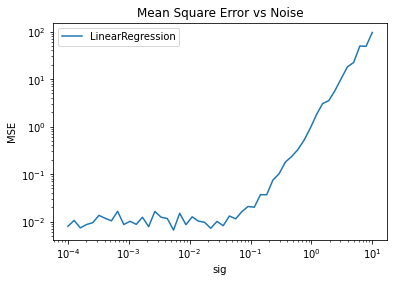

In [11]:
from sklearn.linear_model import LinearRegression

# Initialize parameters and lists
sig = np.logspace(-4, 1)
MSE_LR = []
n = 100
p = 50
N = 100

# Loop over values in sig
for s in sig:
    
    # Generate least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Create a linear regression model and fit it to our least squares data
    model = LinearRegression(fit_intercept=False)
    model.fit(X,y)
    
    # Extract bhat from the coef_ attribute
    bhat_LR = model.coef_
    
    # Append the MSE of the linear regression bhat (bhat_LR) to the list 
    MSE_LR.append(mse(b, bhat_LR, N, s))
    
# Plot MSE_LR against the values of sig
plt.plot(sig, MSE_LR, label='LinearRegression')
plt.title('Mean Square Error vs Noise')
plt.xlabel('sig')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---
Jacobian:
\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{\partial}{\partial b_j} \lambda \sum_i b_{i}^2 
= 2 \lambda \sum_i b_i \delta_{ij} 
= 2 \lambda b_j
\end{equation}
$ J_f(b) = 2\lambda b $

In [12]:
def solve_ridge_opt(X, y, lam=0.1):
    """
    Solves the optimization problem using ridge regression
    minimize_b (1/n * la.norm(X * b - y)**2) + lambda * la.norm(b)**2
    """
    
    p = np.shape(X)[1]

    # Define the function to be minimized
    f = lambda g : (1/n) * np.dot(X @ g - y, X @ g - y) + lam * np.dot(g, g)
    
    # Define its jacobian
    j = lambda g : (2/n) * np.dot(g, X.T @ X) - (2/n) * np.dot(y, X) + 2*lam*g
    
    # Solves the optimization problem using the function and jacobian
    sol = opt.minimize(f, np.zeros(p), jac=j)
    
    return sol.x

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

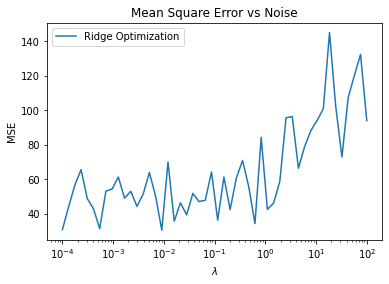

In [13]:
# Initialize parameters and lists
n = 50
p = 100
sig = 0.1
N = 100 # default
lam = np.logspace(-4, 2)
MSE_ro = []

# Loop over values of lambda
for l in lam:
    # Generate least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Solve the problem using ridge optimization
    bhat_ro = solve_ridge_opt(X, y, lam=l)
    
    # Append the MSEs of ridge optimization bhat (bhat_ro) to their list
    MSE_ro.append(mse(b, bhat_ro , N, sig))


# Plot the MSE against he values of lambda
plt.semilogx(lam, MSE_ro, label='Ridge Optimization')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

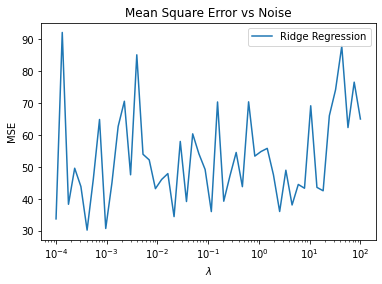

In [14]:
from sklearn.linear_model import Ridge

# Initialize parameters and lists
sig = 0.1
n = 50
p = 100
N = 100 # default
lam = np.logspace(-4, 2)
MSE_R = []

# Loop over values of lambda
for l in lam:
    # Generate least squares problem
    X, y, b = gen_lstsq(n, p)
    
    # Create a Ridge regression model and fit it to our least squares data
    model = Ridge(alpha = l, fit_intercept=False)
    model.fit(X,y)
    
    # Extract bhat from the coef_ attribute
    bhat_R = model.coef_
    
    # Append the MSEs of Ridge regression bhat (bhat_R) to its list
    MSE_R.append(mse(b, bhat_R , N, sig))
    
    
# Plot the MSE against the values of lambda
plt.semilogx(lam, MSE_R, label='Ridge Regression')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [15]:
def gen_lstsq_sparse(n, p, sig=0.1, k=10):
    """
    Generates a linear least squares problem y = X @ b 
    where b is the ground truth solution and is sparse
    """
    
    # Initialize arrays
    X = np.random.randn(n,p)
    b = np.zeros(p)
    y = np.zeros(n)
    
    # Make b sparse by changing k random elements to 1
    for i in range(k):
        entry = np.random.choice(p, replace=False)
        b[entry] = 1
        
    # Solve for y
    for i in range(n):
        y[i] = np.dot(X[i], b) + sig * np.random.randn()
    
    return X, y, b

### Optimization

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---
Jacobian:
\begin{equation}
\frac{\partial f}{\partial b_j} = \frac{\partial}{\partial b_j} \lambda \sum_i |b_{i}|
= \lambda \sum_i \frac{\partial |b_i|}{\partial b_j} \delta_{ij} 
= \pm \lambda
\end{equation} 
I include $\pm$ because if b_i and b_j have different signs then the derivative is -1, but if they have the same sign then the derivative is 1. Also if b_i = 0, then the derivative is 0. 

In [16]:
def solve_lasso_opt(X, y, lam=0.1):
    """
    Solves the optimization problem using lasso (L-1 regularized) regression
    minimize_b (1/n * la.norm(X * b - y)**2) + lambda * la.norm(b, ord=1)
    """
    
    p = np.shape(X)[1]

    # Define the function to be minimized
    f = lambda g : (1/n) * np.dot(X @ g - y, X @ g - y) + lam * la.norm(g, ord=1)
    
    # Define its jacobian
    j = lambda g : (2/n) * np.dot(g, X.T @ X) - (2/n) * np.dot(y, X) + lam * np.sign(g)
    
    # Solve the optimization problem using the function and its jacobian
    sol = opt.minimize(f, np.zeros(p), jac=j)
    
    return sol.x

### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

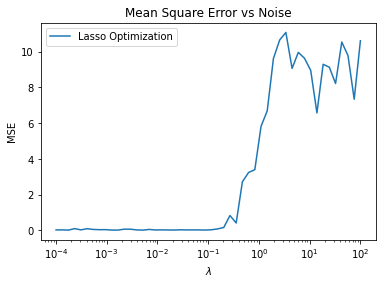

In [17]:
# Initialize parameters and lists
sig = 0.1
n = 50
p = 100
N = 100 # default
k = 10 
lam = np.logspace(-4, 2)
MSE_lasso = []

# Loop over values of lambda
for l in lam:
    
    # Generate a sparse least squares problem
    X, y, b = gen_lstsq_sparse(n, p, sig, k)
    
    # Solve the problem using lasso optimization
    bhat_lasso = solve_lasso_opt(X, y, lam=l)
    
    # Append the MSEs of lasso optimization bhat (bhat_lasso) to the list
    MSE_lasso.append(mse(b, bhat_lasso , N, sig))
    
    
# Plot the MSe against the values of lambda
plt.semilogx(lam, MSE_lasso, label='Lasso Optimization')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()


### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e-02, tolerance: 2.835e-02
  model = cd_fast.enet_coordinate_descent(
/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.667e-02, tolerance: 3.872e-02
  model = cd_fast.enet_coordinate_descent(
/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

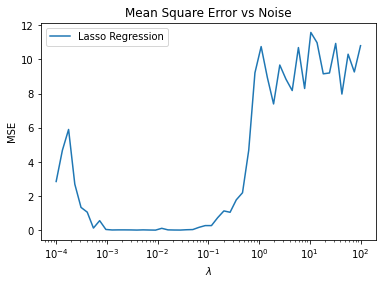

In [18]:
from sklearn.linear_model import Lasso

# Initialize the parameters and lists
sig = 0.1
n = 50
p = 100
N = 100 # default
k = 10
lam = np.logspace(-4, 2)
MSE_L = []

# Loop over values of lambda
for l in lam:
    # Generate a sparse least squares problem
    X, y, b = gen_lstsq_sparse(n, p, sig, k)
    
    # Create a Lasso regression model and fit it to our data
    model = Lasso(alpha = l, fit_intercept=False)
    model.fit(X,y)
    
    # Extract bhat from the attribute coef_
    bhat_L = model.coef_
    
    # Append the MSEs of the Lasso regression bhat (bhat_L) to the list
    MSE_L.append(mse(b, bhat_L , N, sig))
    
    
# Plot the MSE against the values of lambda
plt.semilogx(lam, MSE_L, label='Lasso Regression')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

# I don't know why there's all these warnings (sorry about that)

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---
\begin{equation}
J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X \pm \lambda_1 + 2 \lambda_2 b
\end{equation}

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [19]:
import sklearn.linear_model

class ElasticNet():
    """
    A class that solves least squares problems using L1 and L2 regularization and emulates sklearn.linear_model.ElasticNet
    """
    
    def __init__(self, lam1=0.5, lam2=0.5):
        """
        Adds lam1 and lam2 to the class attributes
        """
        
        self.lam1 = lam1
        self.lam2 = lam2

    def fit(self, X, y):
        """
        Fits the least squares problem data using our optimization minimization model
        """
        
        p = np.shape(X)[1]

        # Define the function to be minimized (using lam1 and lam2)
        f = lambda g : (1/n) * np.dot(X @ g - y, X @ g - y) + self.lam1 * la.norm(g, ord=1) + self.lam2 * np.dot(g, g)
    
        # Define the jacobian
        j = lambda g : (2/n) * np.dot(g, X.T @ X) - (2/n) * np.dot(y, X) + self.lam1 * np.sign(g) + 2 * self.lam2 * g
    
        # Solve the problem using our function and jacobian
        bhat = opt.minimize(f, np.zeros(p), jac=j)
        
        # Save the solution (bhat) as an attribute to the class
        self.bhat = bhat.x
        
        return self.bhat
        
    
    def predict(self, X):
        """
        Predicts the value of y given a matrix X and the fitted solution for bhat
        y = X @ bhat
        """
        
        # Calculate the solution y and saves it as an attribute to the class
        self.y = X @ self.bhat
        
        return self.y

### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

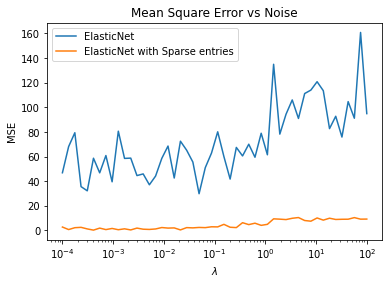

In [20]:
# Initialize parameters and lists
n = 50
p = 100
sig = 0.1
k = 10
N = 100 #default

lam1 = lam2 = np.logspace(-4,2)

MSE_EN = []
MSE_EN_s = []


# Loop over values of lambda where lam1 = lam2
for l in lam1:
    
    # Generate two least squares problems (where one of them is sparse)
    X1, y1, b1 = gen_lstsq(n, p, sig)
    X2, y2, b2 = gen_lstsq_sparse(n, p, sig, k) # Sparse
    
    # Create an ElasticNet model and fit it to each set of data
    model = ElasticNet(lam1=l, lam2=l)
    bhat_1 = model.fit(X1,y1)
    bhat_2 = model.fit(X2,y2) # Sparse
    
    # Append the MSEs of both solutions to their respective lists
    MSE_EN.append(mse(b1, bhat_1 , N, sig))
    MSE_EN_s.append(mse(b2, bhat_2 , N, sig)) # Sparse
    
    
# Plot the MSEs against the values of lambda
plt.semilogx(lam1, MSE_EN, label='ElasticNet')
plt.semilogx(lam1, MSE_EN_s, label='ElasticNet with Sparse entries')
plt.title('Mean Square Error vs Noise')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `windquality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [21]:
# Load the data from the csv file
myDf = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=';')
myDf

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [22]:
from sklearn.model_selection import train_test_split

# Include all data in X except last column
X = myDf[myDf.columns[:-1]]

# Add last column of data to y
y = myDf['quality']

# Split the data into training sets and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a LinearRegression model and fit it to the training set data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the y values using the X test set
y_pred = model.predict(X_test)

# Compare the actual y values (y_test) to the predicted values (y_pred)
mean_squared_error(y_test, y_pred)

0.400780366375006

### Try Some Different Models

Note: you don't need to know anything about these models.  You can just use the `fit` and `predict` methods, and the default parameters.

Use the following `sklearn` classes to fit models and make predictions:
* [`sklearn.ensemble.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* [`sklearn.neural_network.MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)
* [`sklearn.neighbors.KNeighborsRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

Which model gives the best MSE on the test data?

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Model the data using 3 different types of models and compare the predictions of y with the true values

# Model 1 = RandomForestRegressor
model1 = RandomForestRegressor()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

# Model 2 = MLPRegressor
model2 = MLPRegressor()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

# Model 3 = KNeighborsRegressor
model3 = KNeighborsRegressor()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

# Print the calculated mean squared errors 
print("RandomForestRegressor MSE is", mean_squared_error(y_test, y_pred1))
print("MLPRegressor MSE is", mean_squared_error(y_test, y_pred2))
print("KNeighborsRegressor MSE is", mean_squared_error(y_test, y_pred3))

RandomForestRegressor MSE is 0.35159729166666664
MLPRegressor MSE is 0.42460299891587167
KNeighborsRegressor MSE is 0.5365


/home/tokateid/jupyter_env/jupyter_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The RandomForestRegressor gives the best (lowest) MSE for the test data